In [1]:
%run 0_Regressions_Common.ipynb

In [2]:
feature_sets = newcases_feature_sets
label = newcases_label
text_label = "new cases"
text_label_cap = "New Cases"
label_daily = "new_cases_Adj100k"

In [3]:
file_suffix='mar9'

with open('../OtherData/CombinedDFAdjPopulationExcessMobility_%s.pkl' % (file_suffix), 'rb') as handle:
    df = pickle.load(handle)

In [4]:
with open('../OtherData/0_val_7_regions_mar9.pkl', 'rb') as handle:
    val_regions = pickle.load(handle)
     
regions = val_regions
print("Number of val regions: %d" % (len(regions)))

Number of val regions: 7


In [5]:
assert(val_regions == [22, 44, 32, 43, 23, 21, 11])

# Make Predictions

Run validation set feature selection with parameters representing exponentially weighted decay weekly and daily. Only one value should be >0 to represent the decay multiplier. The other value should be 0.

In [6]:
def run_exp_decay_experiments(exp_decay_weekly, exp_decay_daily):

    fs_to_region_to_dynamic_preds = dict()
    fs_to_region_to_osa_preds = dict()
    fs_to_region_to_osa_preds_train = dict()
    fs_to_region_to_osa_preds_dec = dict()

    fs_to_region_to_dynamic_mses = dict()
    fs_to_region_to_dynamic_mas = dict()
    fs_to_region_to_dynamic_mas_new = dict()
    fs_to_region_to_osa_mses = dict()
    fs_to_region_to_osa_mas = dict()
    fs_to_region_to_osa_mas_new = dict()
    fs_to_region_to_osa_mses_dec = dict()
    fs_to_region_to_osa_mas_dec = dict()
    fs_to_region_to_osa_mas_dec_new = dict()

    fs_to_region_to_dynamic_CM = dict()
    fs_to_region_to_osa_CM = dict()
    fs_to_region_to_osa_CM_train = dict()
    fs_to_region_to_osa_CM_dec = dict()
    fs_to_region_to_osa_CM_new = dict()
    fs_to_region_to_osa_CM_train_new = dict()
    fs_to_region_to_osa_CM_dec_new = dict()

    best_mse_fs_mse = 9999
    best_mse_fs_ma = 9999
    best_mse_fs_key = -1
    best_mse_fs_label = "null"

    best_ma_fs_mse = -1
    best_ma_fs_ma = -1
    best_ma_fs_key = -1
    best_ma_fs_label = "null"


    results_df = pd.DataFrame(columns=['Weekly Decay', 'Daily Decay', 'Key', 'Feature Set', 'MSE Nov',
                                       'MA Nov', 'MA (Tier) Nov', 'MSE Dec', 'MA Dec', 'MA (Tier) Dec'])

    for key in feature_sets.keys():
        features = feature_sets[key]

        fs_to_region_to_dynamic_preds[key] = dict()
        fs_to_region_to_osa_preds[key] = dict()
        fs_to_region_to_osa_preds_train[key] = dict()
        fs_to_region_to_osa_preds_dec[key] = dict()

        fs_to_region_to_dynamic_mses[key] = dict()
        fs_to_region_to_dynamic_mas[key] = dict()
        fs_to_region_to_dynamic_mas_new[key] = dict()
        fs_to_region_to_osa_mses[key] = dict()
        fs_to_region_to_osa_mas[key] = dict()
        fs_to_region_to_osa_mas_new[key] = dict()
        fs_to_region_to_osa_mses_dec[key] = dict()
        fs_to_region_to_osa_mas_dec[key] = dict()
        fs_to_region_to_osa_mas_dec_new[key] = dict()

        fs_to_region_to_dynamic_CM[key] = dict()
        fs_to_region_to_osa_CM[key] = dict()
        fs_to_region_to_osa_CM_train[key] = dict()
        fs_to_region_to_osa_CM_dec[key] = dict()
        fs_to_region_to_osa_CM_new[key] = dict()
        fs_to_region_to_osa_CM_train_new[key] = dict()
        fs_to_region_to_osa_CM_dec_new[key] = dict()

        for region in regions:
            region_start = time.time()
            od_df=df.where(df["Region"]==region).dropna()
            train = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-10-24').dropna()
            test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= '2020-12-07').dropna()
            train_dec = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-11-23').dropna()
            dec = od_df.where(od_df["Date"] >= '2020-12-01').where(od_df["Date"] <= '2021-01-07').dropna()

            train_new = train.sort_index().dropna()
            train_dec_new = train_dec.sort_index().dropna()
            test_new = test.sort_index().dropna()
            dec_new = dec.sort_index().dropna()
            features_min_max = preprocessing.MinMaxScaler()
            X_train = features_min_max.fit_transform(train_new[features])
            y_train = train_new[label]
            y_train_eval = train_new[label]
            X_test = features_min_max.transform(test_new[features])
            y_test = test_new[label]
            y_test_eval = test_new[label]
            
            X_train_dec = features_min_max.fit_transform(train_dec_new[features])
            y_train_dec = train_dec_new[label]
            y_train_dec_eval = train_dec_new[label]
            X_dec = features_min_max.transform(dec_new[features])
            y_dec = dec_new[label]
            y_dec_eval = dec_new[label]

            dynamic_preds = make_dynamic_preds(X_train, y_train, X_test, y_test,
                                               exp_decay_weekly=exp_decay_weekly, exp_decay_daily=exp_decay_daily)
            osa_preds = make_osa_preds(X_train, y_train, X_test, y_test,
                                       exp_decay_weekly=exp_decay_weekly, exp_decay_daily=exp_decay_daily)
            osa_preds_dec = make_osa_preds(X_train_dec, y_train_dec, X_dec, y_dec,
                                       exp_decay_weekly=exp_decay_weekly, exp_decay_daily=exp_decay_daily)


            fs_to_region_to_dynamic_preds[key][region] = dynamic_preds
            fs_to_region_to_osa_preds[key][region] = osa_preds
            fs_to_region_to_osa_preds_dec[key][region] = osa_preds_dec

            dynamic_mse = mean_squared_error(dynamic_preds[:-7], y_test_eval[:-7])
            dynamic_ma = magnitude_accuracy_nc(dynamic_preds, y_test_eval)
            dynamic_ma_new = magnitude_accuracy_nct(dynamic_preds, y_test_eval)
            osa_mse = mean_squared_error(osa_preds[:-7], y_test_eval[:-7]) 
            osa_ma = magnitude_accuracy_nc(osa_preds, y_test_eval) 
            osa_ma_new = magnitude_accuracy_nct(osa_preds, y_test_eval) 
            osa_mse_dec = mean_squared_error(osa_preds_dec[:-7], y_dec_eval[:-7]) 
            osa_ma_dec = magnitude_accuracy_nc(osa_preds_dec, y_dec_eval) 
            osa_ma_dec_new = magnitude_accuracy_nct(osa_preds_dec, y_dec_eval) 

            fs_to_region_to_dynamic_mses[key][region] = dynamic_mse
            fs_to_region_to_dynamic_mas[key][region] = dynamic_ma
            fs_to_region_to_osa_mses[key][region] = osa_mse
            fs_to_region_to_osa_mas[key][region] = osa_ma
            fs_to_region_to_osa_mas_new[key][region] = osa_ma_new
            fs_to_region_to_osa_mses_dec[key][region] = osa_mse_dec
            fs_to_region_to_osa_mas_dec[key][region] = osa_ma_dec
            fs_to_region_to_osa_mas_dec_new[key][region] = osa_ma_dec_new

            fs_to_region_to_dynamic_CM[key][region] = confusion_matrix_nc(dynamic_preds, y_test)
            fs_to_region_to_osa_CM[key][region] = confusion_matrix_nc(osa_preds, y_test)
            fs_to_region_to_osa_CM_new[key][region] = confusion_matrix_nct(osa_preds, y_test)
            fs_to_region_to_osa_CM_dec[key][region] = confusion_matrix_nc(osa_preds_dec, y_dec_eval)
            fs_to_region_to_osa_CM_dec_new[key][region] = confusion_matrix_nct(osa_preds_dec, y_dec_eval)

            region_end = time.time()
            
        this_fs_dynamic_average_mse = np.mean(list(fs_to_region_to_dynamic_mses[key].values()))
        this_fs_dynamic_average_ma = np.mean(list(fs_to_region_to_dynamic_mas[key].values()))
        this_fs_osa_average_mse = np.mean(list(fs_to_region_to_osa_mses[key].values()))
        this_fs_osa_average_ma = np.mean(list(fs_to_region_to_osa_mas[key].values()))
        this_fs_osa_average_ma_new = np.mean(list(fs_to_region_to_osa_mas_new[key].values()))
        this_fs_osa_average_mse_dec = np.mean(list(fs_to_region_to_osa_mses_dec[key].values()))
        this_fs_osa_average_ma_dec = np.mean(list(fs_to_region_to_osa_mas_dec[key].values()))
        this_fs_osa_average_ma_dec_new = np.mean(list(fs_to_region_to_osa_mas_dec_new[key].values()))
        
        best_mse_model_mse = this_fs_osa_average_mse
        best_mse_model_ma = this_fs_osa_average_ma
        best_mse_model_ma_new = this_fs_osa_average_ma_new
        best_mse_model_label = "osa"
        best_mse_model_mse_dec = this_fs_osa_average_mse_dec
        best_mse_model_ma_dec = this_fs_osa_average_ma_dec
        best_mse_model_ma_dec_new = this_fs_osa_average_ma_dec_new

        if best_mse_model_mse < best_mse_fs_mse:
            best_mse_fs_mse = best_mse_model_mse
            best_mse_fs_ma = best_mse_model_ma
            best_mse_fs_key = key
            best_mse_fs_label = best_mse_model_label
    
        results_df = results_df.append({'Weekly Decay': exp_decay_weekly,
                                        'Daily Decay': exp_decay_daily,
                                        'Key': key,
                                        'Feature Set': feature_sets[key],
                                        'MSE Nov': best_mse_model_mse,
                                        'MA Nov': best_mse_model_ma,
                                        'MA (Tier) Nov': best_mse_model_ma_new,
                                        'MSE Dec': best_mse_model_mse_dec,
                                        'MA Dec': best_mse_model_ma_dec,
                                       'MA (Tier) Dec': best_mse_model_ma_dec_new}, ignore_index=True)
    
    print("Best Feature set based on MSE: %d %s %s \t MSE: %.7f\t MA: %.7f" % (best_mse_fs_key, best_mse_fs_label,
                                                              feature_sets[best_mse_fs_key],
                                                              best_mse_fs_mse, best_mse_fs_ma))
    
    return results_df, fs_to_region_to_dynamic_preds, fs_to_region_to_osa_preds, fs_to_region_to_osa_preds_dec

In [7]:
results_df_list = list()
dynamic_preds_list = list()
osa_preds_list = list()
dec_osa_preds_list = list()

decays = [0.5**0.5]

this_r_df, this_dynamic_preds, this_osa_preds, this_dec_preds = run_exp_decay_experiments(0, 0)
results_df_list.append(this_r_df)
dynamic_preds_list.append(this_dynamic_preds)
osa_preds_list.append(this_osa_preds)
dec_osa_preds_list.append(this_dec_preds)

for weekly_decay in decays:
    this_r_df, this_dynamic_preds, this_osa_preds, this_dec_preds = run_exp_decay_experiments(weekly_decay, 0)
    results_df_list.append(this_r_df)
    dynamic_preds_list.append(this_dynamic_preds)
    osa_preds_list.append(this_osa_preds)
    dec_osa_preds_list.append(this_dec_preds)

Best Feature set based on MSE: 18 osa ['New_Cases_7_Adj100k_1dayago', 'Diff Internal_Movement_7_Adj100k_1dayago', 'New_Tests_7_Adj100k_1dayago'] 	 MSE: 10.1610987	 MA: 0.6619048
Best Feature set based on MSE: 11 osa ['New_Cases_7_Adj100k_1dayago', 'Excess Pressure_7_Adj100k_1dayago'] 	 MSE: 11.5442951	 MA: 0.6523810


In [8]:
all_results = pd.concat(results_df_list)

In [9]:
results_to_consider = all_results.where(all_results["MSE Dec"] >=0).dropna()
results_to_consider["Eval MSE"] = (results_to_consider["MSE Nov"] * 30 + results_to_consider["MSE Dec"] * 31) / (61)

results_to_consider["Eval MA"] = (results_to_consider["MA Nov"] * 30 + results_to_consider["MA Dec"] * 31) / (61)

results_to_consider["Eval MA (Tier)"] = (results_to_consider["MA (Tier) Nov"] * 30 + results_to_consider["MA (Tier) Dec"] * 31) / (61)
results_to_consider.sort_values(by=['Eval MSE'], ascending=True).head(15)

,Weekly Decay,Daily Decay,Key,Feature Set,MSE Nov,MA Nov,MA (Tier) Nov,MSE Dec,MA Dec,MA (Tier) Dec,Eval MSE,Eval MA,Eval MA (Tier)
6,0.707107,0,7,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",14.664211,0.619048,0.561905,75.113464,0.889401,0.668203,45.384323,0.756440,0.615925
31,0.707107,0,32,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",14.234853,0.666667,0.519048,76.979458,0.884793,0.741935,46.121455,0.777518,0.632319
16,0.707107,0,17,"[New_Cases_7_Adj100k_1dayago, Excess Internal_...",13.083123,0.676190,0.533333,79.000173,0.884793,0.737327,46.581952,0.782201,0.637002
2,0.707107,0,3,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",21.397788,0.576190,0.485714,71.488233,0.894009,0.682028,46.853588,0.737705,0.585480
43,0.707107,0,44,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",18.246048,0.623810,0.490476,76.539516,0.880184,0.737327,47.870597,0.754098,0.615925
10,0.707107,0,11,"[New_Cases_7_Adj100k_1dayago, Excess Pressure_...",11.544295,0.652381,0.576190,85.904873,0.889401,0.658986,49.334097,0.772834,0.618267
38,0.707107,0,39,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",18.539382,0.666667,0.609524,97.166010,0.880184,0.654378,58.497177,0.775176,0.632319
25,0.707107,0,26,"[New_Cases_7_Adj100k_1dayago, Excess Internal_...",18.000322,0.680952,0.614286,97.905114,0.889401,0.658986,58.607675,0.786885,0.637002
46,0.707107,0,47,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",39.849203,0.533333,0.328571,77.709876,0.870968,0.640553,59.089873,0.704918,0.487119
51,0.707107,0,52,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",24.658879,0.595238,0.423810,92.955352,0.894009,0.585253,59.366923,0.747073,0.505855


In [10]:
results_to_consider.sort_values(by=['Eval MA (Tier)'], ascending=False).head(15)

,Weekly Decay,Daily Decay,Key,Feature Set,MSE Nov,MA Nov,MA (Tier) Nov,MSE Dec,MA Dec,MA (Tier) Dec,Eval MSE,Eval MA,Eval MA (Tier)
50,0.707107,0,51,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",18.377062,0.604762,0.619048,100.447103,0.884793,0.658986,60.084788,0.747073,0.639344
16,0.707107,0,17,"[New_Cases_7_Adj100k_1dayago, Excess Internal_...",13.083123,0.676190,0.533333,79.000173,0.884793,0.737327,46.581952,0.782201,0.637002
25,0.707107,0,26,"[New_Cases_7_Adj100k_1dayago, Excess Internal_...",18.000322,0.680952,0.614286,97.905114,0.889401,0.658986,58.607675,0.786885,0.637002
31,0.707107,0,32,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",14.234853,0.666667,0.519048,76.979458,0.884793,0.741935,46.121455,0.777518,0.632319
38,0.707107,0,39,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",18.539382,0.666667,0.609524,97.166010,0.880184,0.654378,58.497177,0.775176,0.632319
14,0,0,15,"[New_Cases_7_Adj100k_1dayago, Excess Pressure_...",72.055379,0.552381,0.571429,231.273393,0.907834,0.668203,152.969452,0.733021,0.620609
10,0.707107,0,11,"[New_Cases_7_Adj100k_1dayago, Excess Pressure_...",11.544295,0.652381,0.576190,85.904873,0.889401,0.658986,49.334097,0.772834,0.618267
43,0.707107,0,44,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",18.246048,0.623810,0.490476,76.539516,0.880184,0.737327,47.870597,0.754098,0.615925
6,0.707107,0,7,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",14.664211,0.619048,0.561905,75.113464,0.889401,0.668203,45.384323,0.756440,0.615925
7,0,0,8,"[New_Cases_7_Adj100k_1dayago, New_Cases_7_Adj1...",11.487099,0.580952,0.595238,285.164933,0.894009,0.626728,150.569277,0.740047,0.611241


In [11]:
toplot_x = np.sqrt(results_to_consider["MSE Nov"])
toplot_y = np.sqrt(np.array(results_to_consider["MSE Dec"], dtype=np.float64))

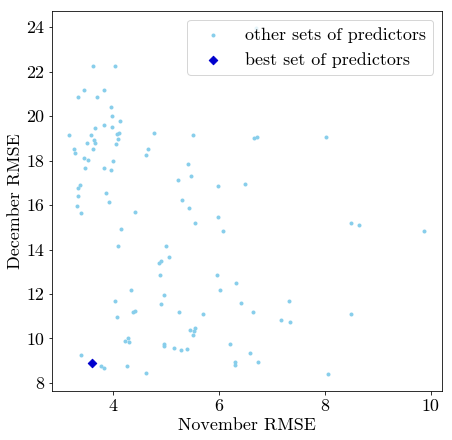

In [12]:
change_font_size(18)
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(toplot_x, toplot_y, label="other sets of predictors", marker='.', color='skyblue')
plt.scatter(np.sqrt(results_to_consider["MSE Nov"].loc[16].iloc[1]), np.sqrt(results_to_consider["MSE Dec"].loc[16].iloc[1]),
            color='mediumblue', label='best set of predictors', marker='D')
plt.xlabel("November RMSE")
plt.ylabel("December RMSE")
plt.legend()
plt.show()

In [13]:
cms = list()
cms_old = list()

for region in regions:
     
    od_df=df.where(df["Region"]==region).dropna()
    train = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-10-24').dropna()
    test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= '2020-12-07').dropna()
    dec = od_df.where(od_df["Date"] >= '2020-12-01').where(od_df["Date"] <= '2021-01-07').dropna()

    train_new = train.sort_index().dropna()
    test_new = test.sort_index().dropna()
    dec_new = dec.sort_index().dropna()
    y_train = train_new[label]
    y_test = test_new[label]
    y_dec = dec_new[label] 
    
    train_copy = train.copy()
    test_copy = test.copy()
    dec_copy = dec.copy()

    train_copy["actual"] = y_train
    train_copy["pred"] = y_train
    test_copy["actual"] = y_test
    test_copy["best_mse"] = osa_preds_list[1][17][region]
    dec_copy["actual"] = y_dec
    dec_copy["best_mse"] = dec_osa_preds_list[1][17][region]
    
    cm = confusion_matrix_nct(dec_copy["best_mse"], dec_copy["actual"])
    cms.append(cm)
    cm = confusion_matrix_nc(dec_copy["best_mse"], dec_copy["actual"])
    cms_old.append(cm)
    cm = confusion_matrix_nct(test_copy["best_mse"], test_copy["actual"])
    cms.append(cm)
    cm = confusion_matrix_nc(test_copy["best_mse"], test_copy["actual"])
    cms_old.append(cm)

In [14]:
train_cm = sum(cms)

In [15]:
train_cm

array([[ 2, 34,  5,  0,  0],
       [13, 79, 21,  0,  0],
       [ 0, 25, 44,  4,  0],
       [ 0,  2, 24, 80,  8],
       [ 0,  0,  0, 19, 67]], dtype=int64)

In [16]:
train_cm.sum(axis=None)

427

In [17]:
train_cm_old = sum(cms_old)

In [18]:
train_cm_old

array([[  0,   2,   0,   0],
       [  0,  30,  37,  10],
       [  0,  10,  24,  14],
       [  0,   4,  16, 280]], dtype=int64)

In [19]:
train_cm.sum(axis=1) / sum(sum(train_cm))

array([0.09601874, 0.264637  , 0.17096019, 0.26697892, 0.20140515])

In [20]:
train_cm_old.sum(axis=1) / sum(sum(train_cm_old))

array([0.00468384, 0.18032787, 0.11241218, 0.70257611])

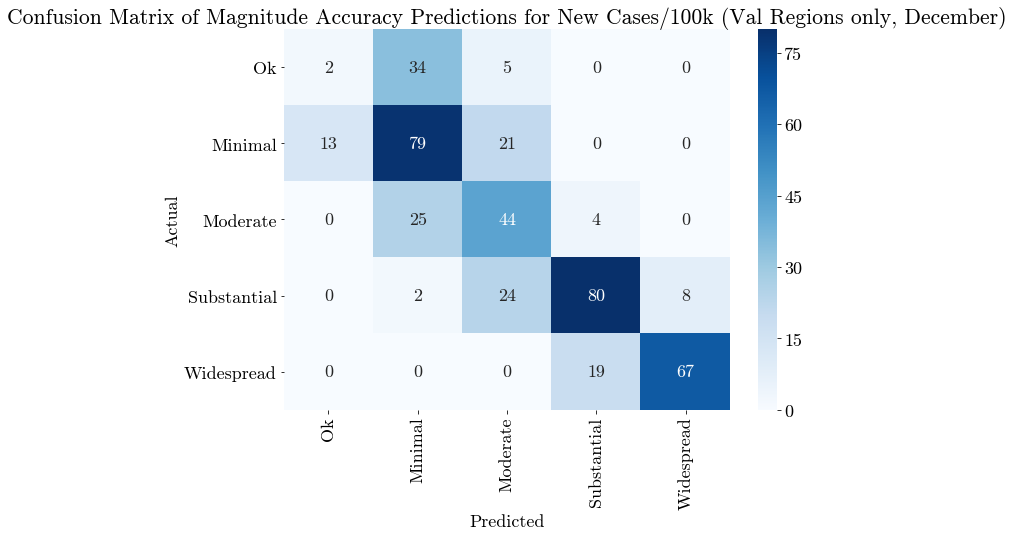

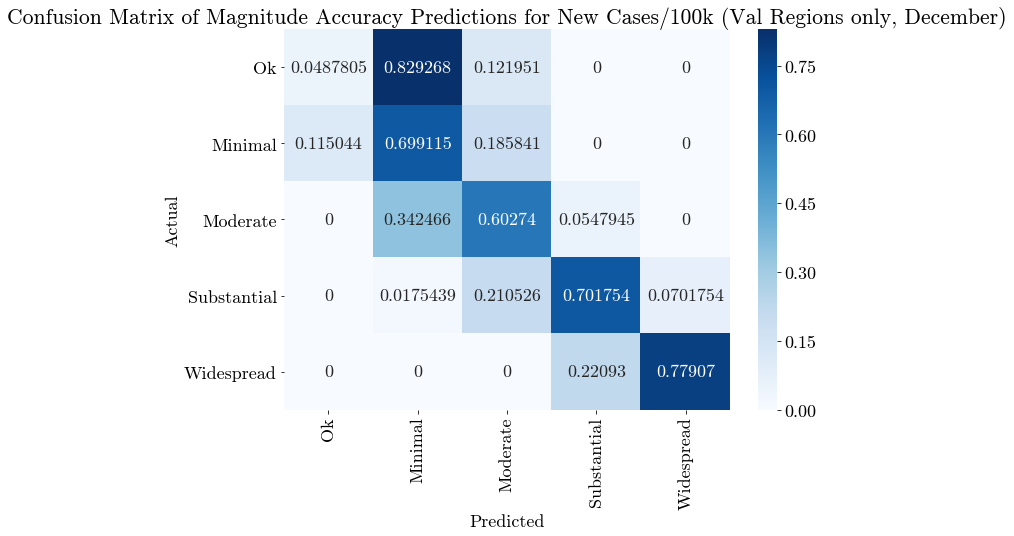

In [21]:


df_cm = pd.DataFrame(train_cm, index = ["Ok", "Minimal", "Moderate", "Substantial", "Widespread"],
                  columns = ["Ok", "Minimal", "Moderate", "Substantial", "Widespread"])
plt.figure(figsize = (10,7))
ax = plt.axes()
sns.heatmap(df_cm, annot=True, ax = ax, cmap="Blues", fmt='g')
ax.set_title("Confusion Matrix of Magnitude Accuracy Predictions for New Cases/100k (Val Regions only, December)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()

df_cm = pd.DataFrame(normalize_cm(train_cm), index = ["Ok", "Minimal", "Moderate", "Substantial", "Widespread"],
                  columns = ["Ok", "Minimal", "Moderate", "Substantial", "Widespread"])
plt.figure(figsize = (10,7))
ax = plt.axes()
sns.heatmap(df_cm, annot=True, ax = ax, cmap="Blues", fmt='g')
ax.set_title("Confusion Matrix of Magnitude Accuracy Predictions for New Cases/100k (Val Regions only, December)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()

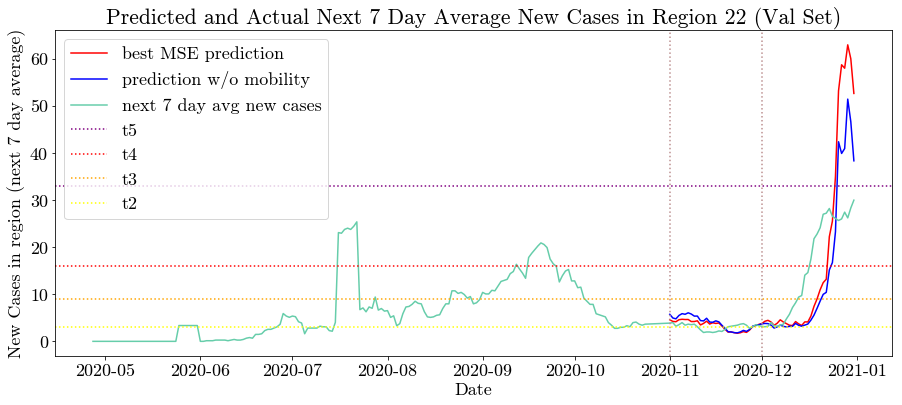

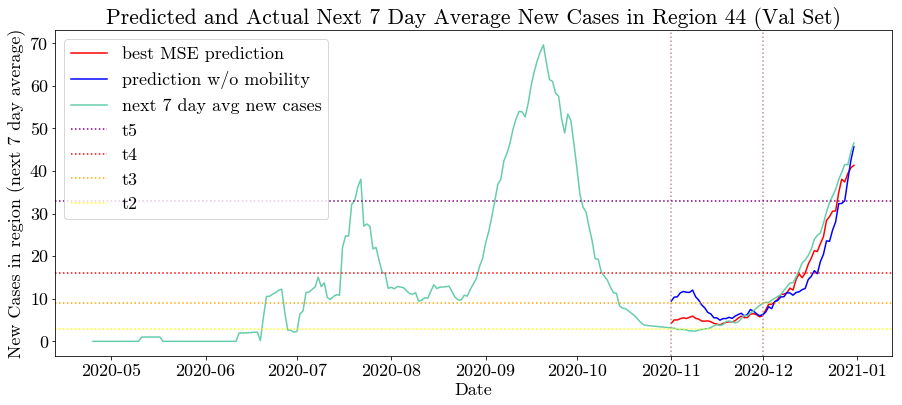

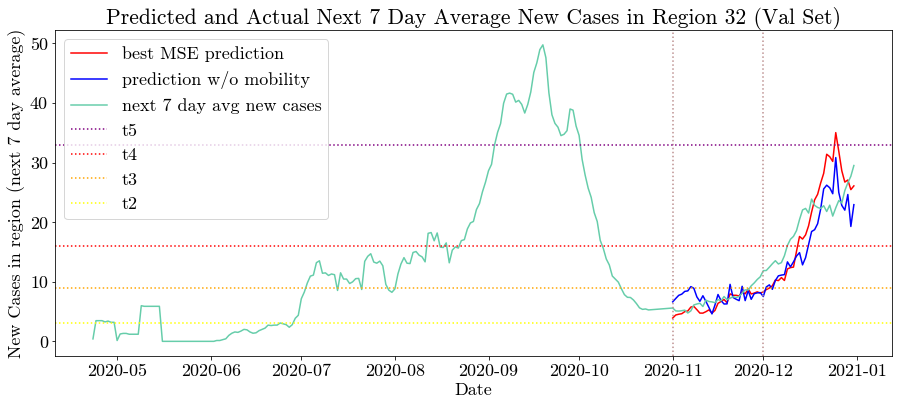

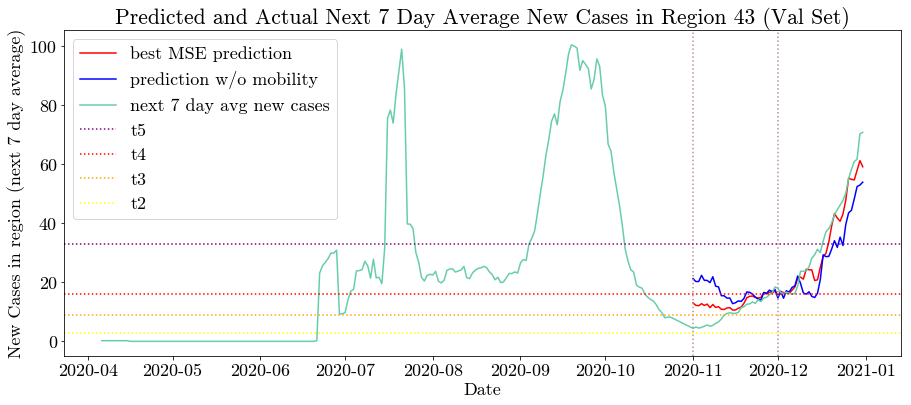

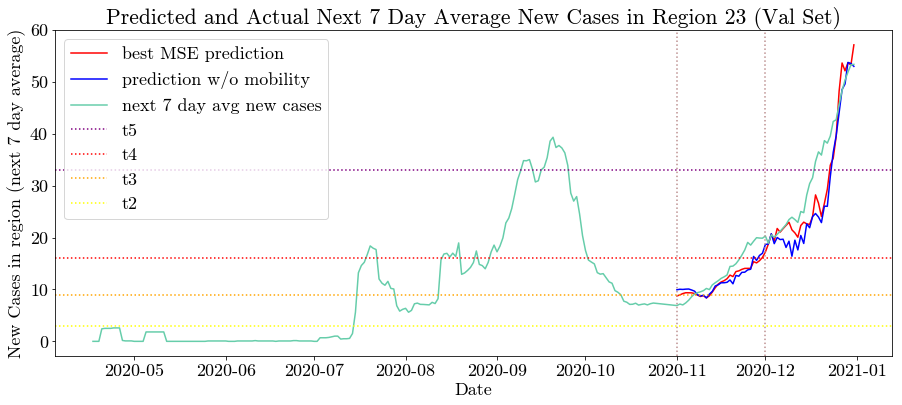

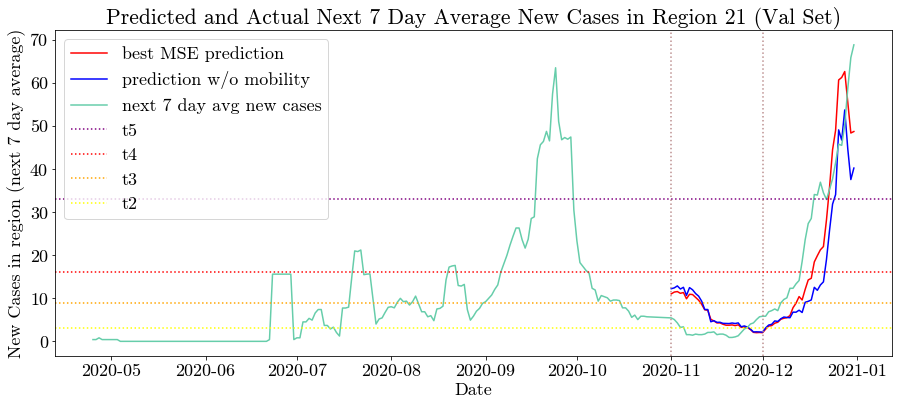

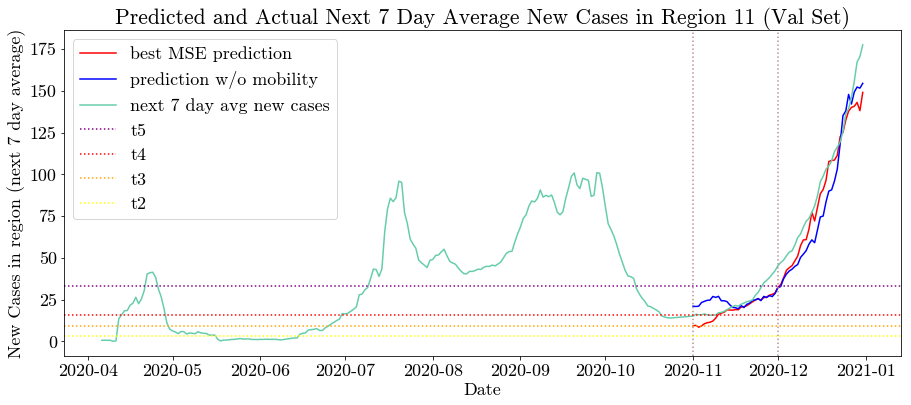

In [22]:
for region in regions:
     
    od_df=df.where(df["Region"]==region).dropna()
    train = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-10-24').dropna()
    test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= test_end_nov).dropna()
    dec = od_df.where(od_df["Date"] >= '2020-12-01').where(od_df["Date"] <= '2020-12-31').dropna()

    train_new = train.sort_index().dropna()
    test_new = test.sort_index().dropna()
    dec_new = dec.sort_index().dropna()
    y_train = train_new[label]
    y_test = test_new[label]
    y_dec = dec_new[label] 
    
    train_copy = train.copy()
    test_copy = test.copy()
    dec_copy = dec.copy()

    train_copy["actual"] = y_train
    train_copy["pred"] = y_train
    test_copy["actual"] = y_test
    test_copy["best_mse"] = osa_preds_list[1][17][region][:-7]
    test_copy["without_mobility"] = osa_preds_list[1][4][region][:-7]
    dec_copy["actual"] = y_dec
    dec_copy["best_mse"] = dec_osa_preds_list[1][17][region][:-7]
    dec_copy["without_mobility"] = dec_osa_preds_list[1][4][region][:-7]
        
    pred_all = pd.concat([train_copy, test_copy, dec_copy])

    # plot the final result on a sample dataset    
    toplot = pred_all
    toplot['Date'] = pd.to_datetime(toplot['Date'])
    fig, ax = plt.subplots(figsize=(15,6))
    plt.plot(toplot['Date'], toplot['best_mse'], color='red', label='best MSE prediction')
    plt.plot(toplot['Date'], toplot['without_mobility'], color='blue', label='prediction w/o mobility')
    plt.plot(toplot['Date'], toplot['actual'], color='mediumaquamarine', label='next 7 day avg %s' % (text_label))
    plt.axvline(x='2020-12-01', color='rosybrown', linestyle='dotted')
    plt.axvline(x='2020-11-01', color='rosybrown', linestyle='dotted')
    plt.axhline(y=t5_nct, color='purple', linestyle='dotted', label='t5')
    plt.axhline(y=t4_nct, color='red', linestyle='dotted', label='t4')
    plt.axhline(y=t3_nct, color='orange', linestyle='dotted', label='t3')
    plt.axhline(y=t2_nct, color='yellow', linestyle='dotted', label='t2')
    plt.legend(loc=0)
    plt.xlabel("Date")
    plt.ylabel("%s in region (next 7 day average)" % (text_label_cap))
    plt.title("Predicted and Actual Next 7 Day Average %s in Region %d (Val Set)" % (text_label_cap, region))
    plt.show()

# Dump Validation Set predictions to file

In [23]:
# dump experiments on exp decay results df and predictions
dump_to_pickle(all_results, '../OtherData/NewCasesExpDecayValSetResults_%s.pkl' % (file_suffix))
dump_to_pickle(dynamic_preds_list, '../OtherData/NewCasesExpDecayValSetDynamicPreds_%s.pkl' % (file_suffix))
dump_to_pickle(osa_preds_list, '../OtherData/NewCasesExpDecayValSetOSAPreds_%s.pkl' % (file_suffix))
dump_to_pickle(dec_osa_preds_list, '../OtherData/NewCasesExpDecayValSetOSAPredsDec_%s.pkl' % (file_suffix))

Saved file
Saved file
Saved file
Saved file


In [24]:
results_to_consider.to_csv("../OtherData/NewCasesExpResults_%s.csv" % (file_suffix))

In [25]:

with open('../OtherData/RegionColor.pkl', 'rb') as handle:
    colors = pickle.load(handle)
with open('../OtherData/RegionDarkColor.pkl', 'rb') as handle:
    dark_colors = pickle.load(handle)

In [26]:
df["rolling_std"] = df.groupby('Region')[label].transform(lambda x: x.rolling(14, 1).std())


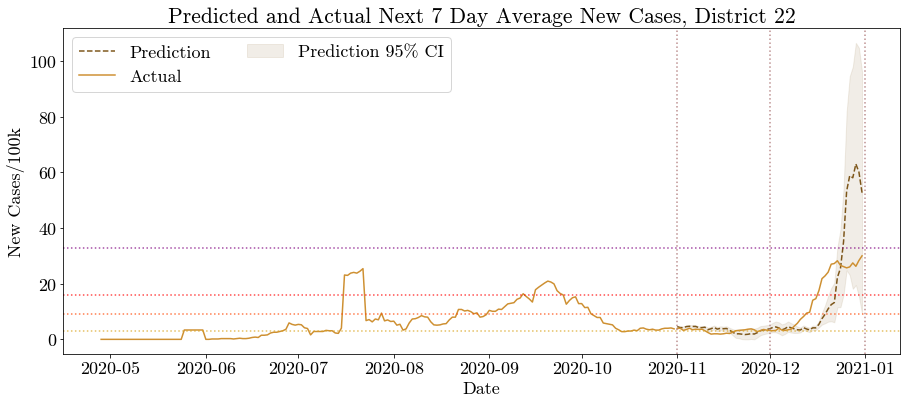

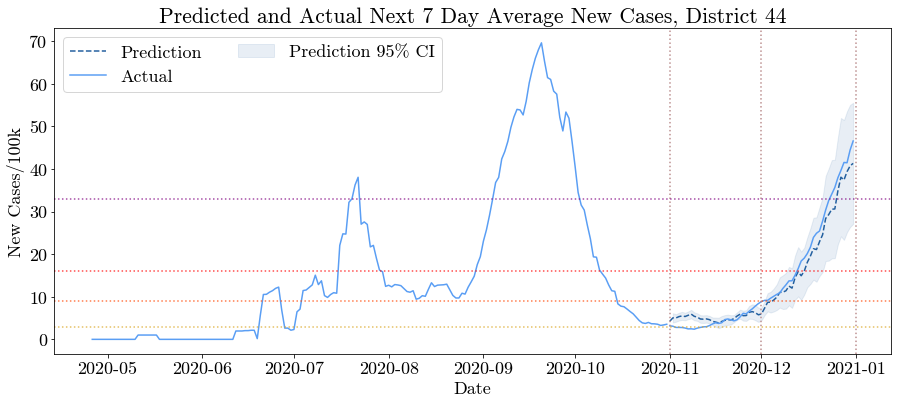

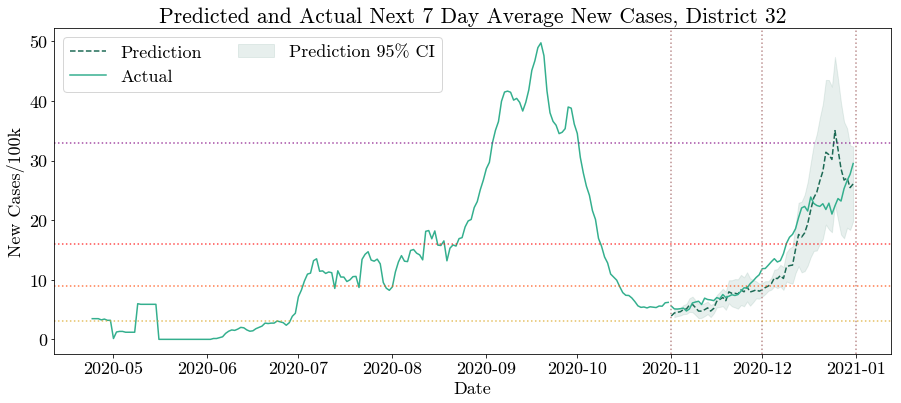

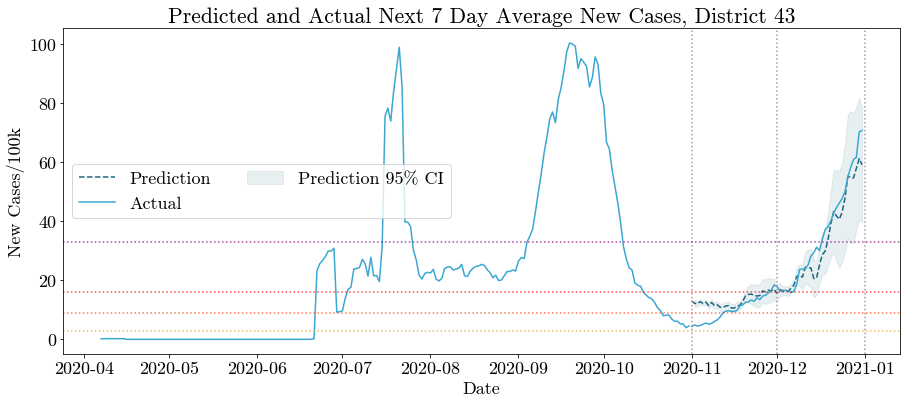

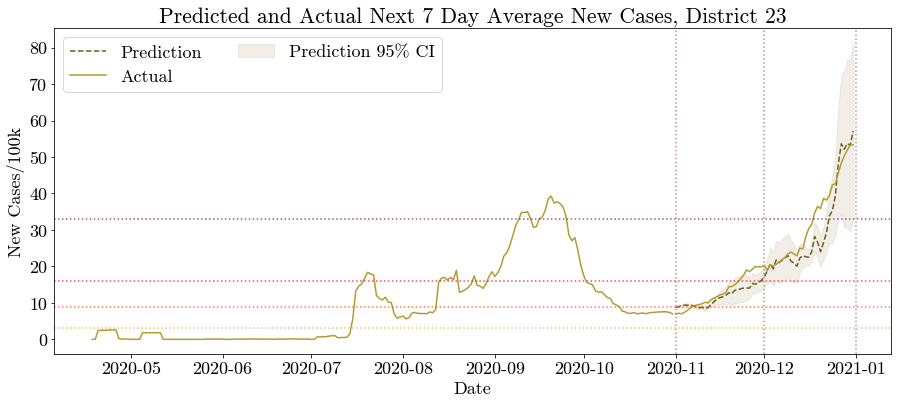

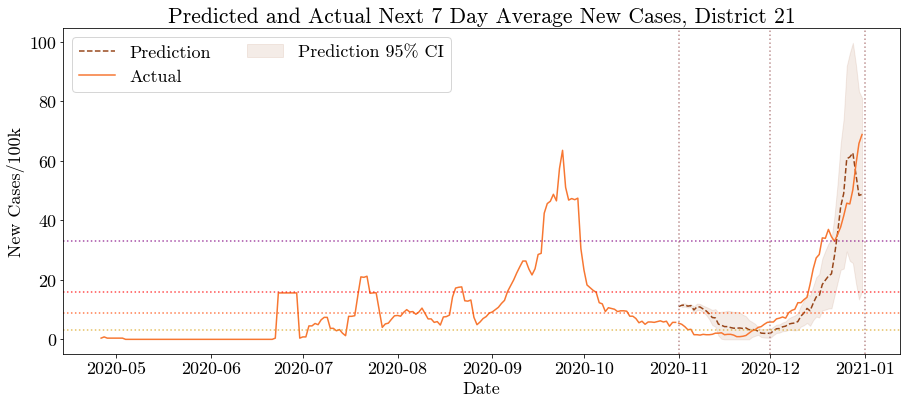

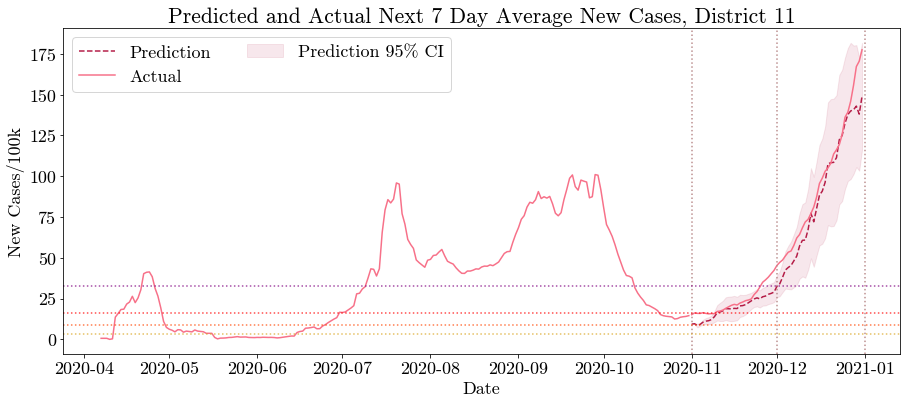

In [27]:
for i in range(len(regions)):
     
    region = regions[i]
    color = colors[region]
    dark_color = dark_colors[region]
    
    od_df=df.where(df["Region"]==region).dropna()
    train = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-10-31').dropna()
    test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= '2020-11-30').dropna()
    dec = od_df.where(od_df["Date"] >= '2020-12-01').where(od_df["Date"] <= '2020-12-31').dropna()

    train_new = train.sort_index().dropna()
    test_new = test.sort_index().dropna()
    dec_new = dec.sort_index().dropna()
    y_train = train_new[label]
    y_test = test_new[label]
    y_dec = dec_new[label] 
    
    train_copy = train.copy()
    test_copy = test.copy()
    dec_copy = dec.copy()

    train_copy["actual"] = y_train
    train_copy["pred"] = y_train
    test_copy["actual"] = y_test
    test_copy["best_mse"] = osa_preds_list[1][17][region][:-7]
    dec_copy["actual"] = y_dec
    dec_copy["best_mse"] = dec_osa_preds_list[1][17][region][:-7]
    
    pred_temp = pd.concat([test_copy, dec_copy])
    
    pred_temp["rolling_std"] = pred_temp.groupby('Region')["best_mse"].transform(lambda x: x.rolling(14, 1).std())
    lower_bound_test = np.maximum(0,pred_temp['best_mse'] - 1.96*pred_temp["rolling_std"])
    upper_bound_test = pred_temp['best_mse'] + 1.96*pred_temp["rolling_std"]
    pred_all = pd.concat([train_copy, pred_temp])
    
    fig, ax = plt.subplots(figsize=(15,6))

    # plot the final result on a sample dataset    
    toplot = pred_all
    toplot['Date'] = pd.to_datetime(toplot['Date'])
    test_copy['Date'] = pd.to_datetime(test_copy['Date'])
    plt.fill_between(pred_temp['Date'].values, y1=lower_bound_test, y2=upper_bound_test, color=dark_color, alpha=.1, label="Prediction 95% CI")
    
    plt.plot(toplot['Date'], toplot['best_mse'], color=dark_color, linestyle='--', label='Prediction')
    plt.plot(pred_temp['Date'], pred_temp['actual'], color=color, label='_Hidden')
    plt.plot(train_copy['Date'], train_copy['actual'], color=color, label='Actual')
    plt.axvline(x='2020-12-01', color='rosybrown', linestyle='dotted')
    plt.axvline(x='2020-11-01', color='rosybrown', linestyle='dotted')
    plt.axvline(x='2021-01-01', color='rosybrown', linestyle='dotted')
    plt.xlabel("Date")
    plt.ylabel("New Cases/100k")
    plt.title("Predicted and Actual Next 7 Day Average New Cases, District %d" % (region))
    plt.axhline(y=t5_nct, color='purple', linestyle='dotted', label='_Tier 5', alpha=0.7)
    plt.axhline(y=t4_nct, color='red', linestyle='dotted', label='_Tier 4', alpha=0.7)
    plt.axhline(y=t3_nct, color='orangered', linestyle='dotted', label='_Tier 3', alpha=0.7)
    plt.axhline(y=t2_nct, color='goldenrod', linestyle='dotted', label='_Tier 2', alpha=0.7)
    plt.legend(loc=0, ncol=2)
    plt.show()